# Анализ, прогнозирование и разработка стратегии в работе с клиентами сети фитнес-центров

# Описание. Задача
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 

**Задача:** провести анализ и подготовить план действий по удержанию клиентов.
А именно:

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - 1) выделить целевые группы клиентов;
    - 2) предложить меры по снижению оттока;
    - 3) определить другие особенности взаимодействия с клиентами.


## Загрузка данных, предварительный анализ
«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
- Данные клиента за предыдущий до проверки факта оттока месяц:
    - 'gender' — пол (можно считать, что для "gender" 0 - мужчины, 1 - женщины, но это не принципиально);
    - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
    - 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
    - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    - 'Phone' — наличие контактного телефона;
    - 'Age' — возраст;
    - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    - 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
    - 'Group_visits' — факт посещения групповых занятий;
    - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
    - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
    - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце (1 - это отток). 

In [1]:
import pandas as pd   # Загрузим необходимые библиотеки
import seaborn as sns              
import matplotlib.pyplot as plt    
import itertools           
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split   
from sklearn.linear_model import LogisticRegression    
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier    
from sklearn.metrics import accuracy_score, precision_score, recall_score    
from sklearn.cluster import KMeans   
from scipy.cluster.hierarchy import dendrogram, linkage   


import warnings # отключили предупреждения           
warnings.filterwarnings('ignore')                    

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')  # прочитаем из csv-файла данные

print(data.info()) # распечатаем информацию 
data.head()        # и первые 5 строк

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Пропущенных значений нет. Формат данных соответствует. Проверим дубликаты.

In [3]:
print('Количество дубликатов в таблице:', data.duplicated().sum())

Количество дубликатов в таблице: 0


Итак, имеем таблицу с 4000 записей, без пропущеных значений и дубликатов, все значения числовые.

Осталось изменить имена столбцов согласно правилу хорошего стиля (заменить на нижний регистр), и можно будет переходить к исследовательскому анализу.

In [4]:
for index in range(len(data.columns)):                                  # Перебираем индексы для столбцов
    data = data.rename(
        columns={data.columns[index] : data.columns[index].lower()}     # Переименовываем, используя ф-цию замены на строчные
    )   

## Исследовательский анализ данных (EDA)
Посмотрим на датасет с точки зрения основных статистических характеристик данных: минимальные, максимальные, средние значения,  стандартные отклонения. Воспользуемся методом describe().

In [5]:
data.describe().T  # транспонировали для удобства восприятия таблицы

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Каких-либо выбросов не наблюдается, все значения в пределах разумного.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался. Для этого воспользуемся методом groupby().


In [6]:
data.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


#### Предварительные выводы
Ни пол, ни наличие оставленного телефона никак не влияют на отток, остающиеся чуть старше и более склонны к дополнительным тратам, занимаются чаще. Важным фактором кажется длительность абонемента, чем больший срок, тем меньше отток. Нашел отражение факт удаленности, чем ближе к фитнес-центру, тем реже бросают ходить. На первый взгляд, партнерская программа и скидки по промо-коду тоже значительно уменьшают шанс забросить занятия.

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток). Создадим словарь подписей к графикам и разобьем столбцы на условно дискретные (значения да-нет и период контракта в 2, 6 и 12 мес.) и условно непрерывные, такие как возраст, выручка, месяцы и частота занятий).

In [7]:
titles = {'gender': 'Пол',
         'near_location': 'Проживание возле фитнес-центра',
         'partner': 'Партнерская программа',
         'promo_friends': 'Факт использования промо-кода при оплате первого абонемента',
         'phone': 'Наличие оставленного телефона',
         'contract_period': 'Длительность текущего действующего абонемента, мес.',
         'group_visits': 'Посещение групповых занятий',
         'age': 'Возраст, лет',
         'avg_additional_charges_total': 'Суммарная выручка от других услуг фитнес-центра, у.е.',
         'month_to_end_contract': 'Месяцев до окончания контракта, мес.',
         'lifetime': 'Время с момента первого обращения в фитнес-центр, мес.',
         'avg_class_frequency_total': 'Средняя частота посещений в неделю за все время с начала действия абонемента, раз',
         'avg_class_frequency_current_month': 'Средняя частота посещений в неделю за предыдущий месяц, раз',
         'churn': 'Отток'}
col_discrete = ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'churn']
col_continuous = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month']


### Гистограммы и распределения

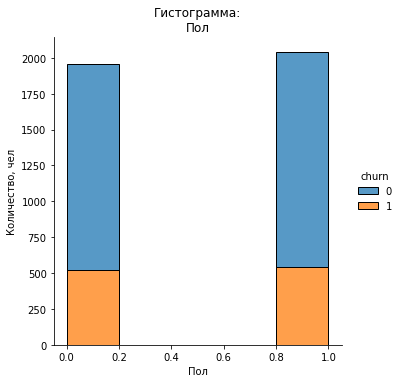

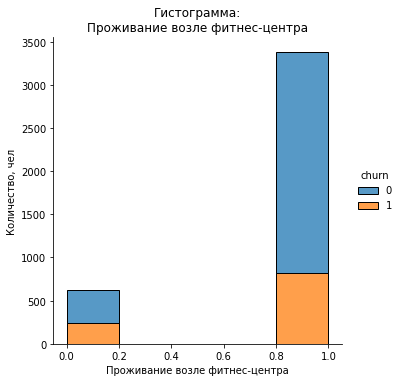

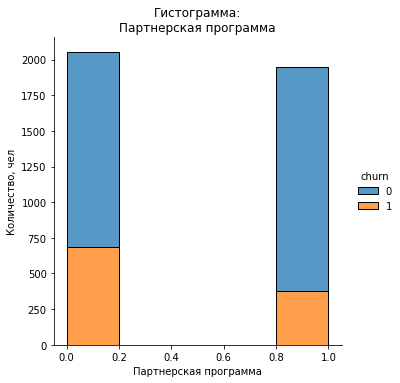

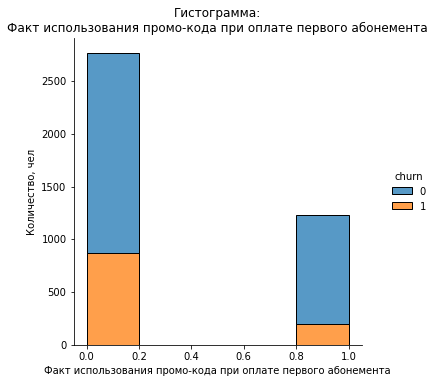

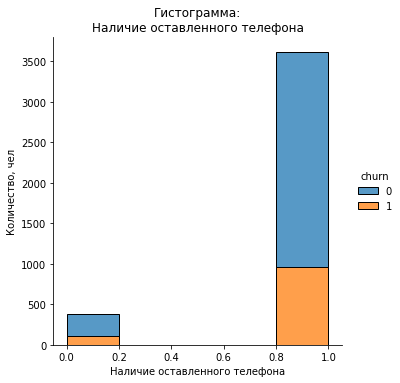

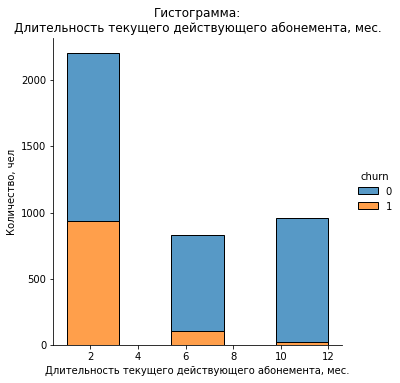

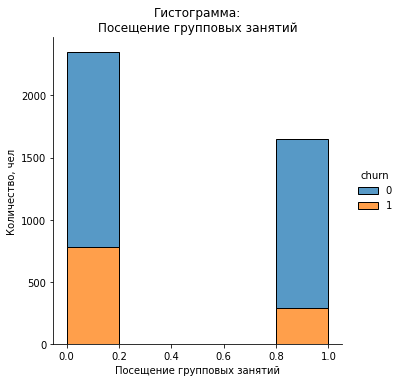

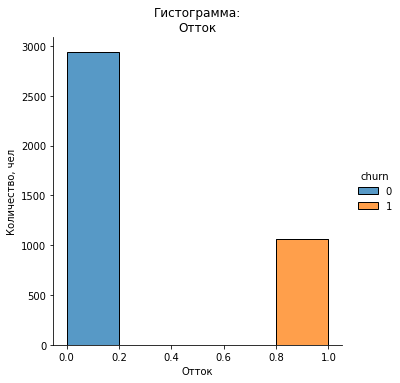

In [8]:
for column in col_discrete:
    sns.displot(x=column,
            hue='churn',       # разбивка цветом по оттоку
            bins = 5,
            multiple='stack',  # накопительные
            data=data)
    
    plt.ylabel('Количество, чел')
    plt.xlabel(titles.get(column))
    plt.title('Гистограмма:\n'+ titles.get(column))
    plt.show()

На графиках ниже использованы цвета: blue - для тех, кто остались, orange - отток


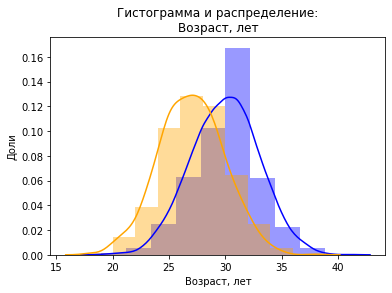

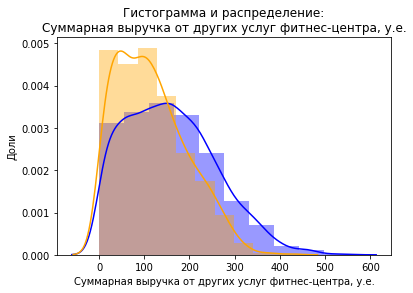

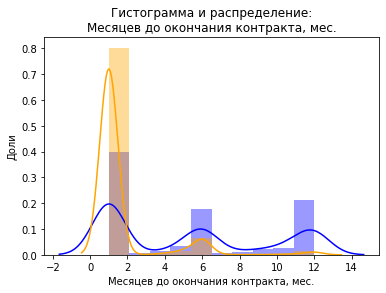

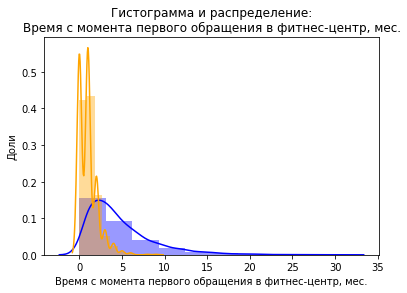

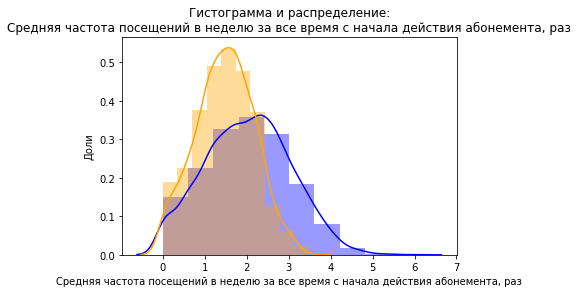

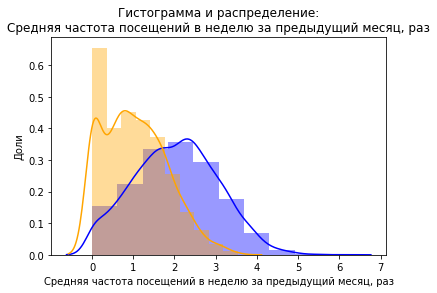

In [9]:
print('На графиках ниже использованы цвета: blue - для тех, кто остались, orange - отток')
for column in col_continuous:

    sns.distplot(data.query('churn == 0')[column], bins = 10, color='blue') 
    sns.distplot(data.query('churn == 1')[column], bins = 10, color='orange')
            
    plt.ylabel('Доли')
    plt.xlabel(titles.get(column))
    plt.title('Гистограмма и распределение:\n'+ titles.get(column))
      
    plt.show()

#### Выводы по гистограммам
Графики еще раз подтверждают предварительные выводы. Ни пол, ни наличие оставленного телефона не влияют на отток. Партнерская программа, скидки по промо-коду, проживание поблизости - это плюс. Средний возраст остающихся чуть больше (самые упорные - около 30-32 лет). При длительности абонемента 2 мес. уходит почти каждый второй, 6 мес. - уже только каждый восьмой, а если 12 мес. - доля ушедших совсем мала. Кто уходит, занимался реже (1-2-3 раза в неделю), а под конец в последний месяц и того реже, кто остался, занимаются чаще (2-3-4 раза в неделю).

### Матрица корреляций 
Построим и отрисуем теперь матрицу корреляций.

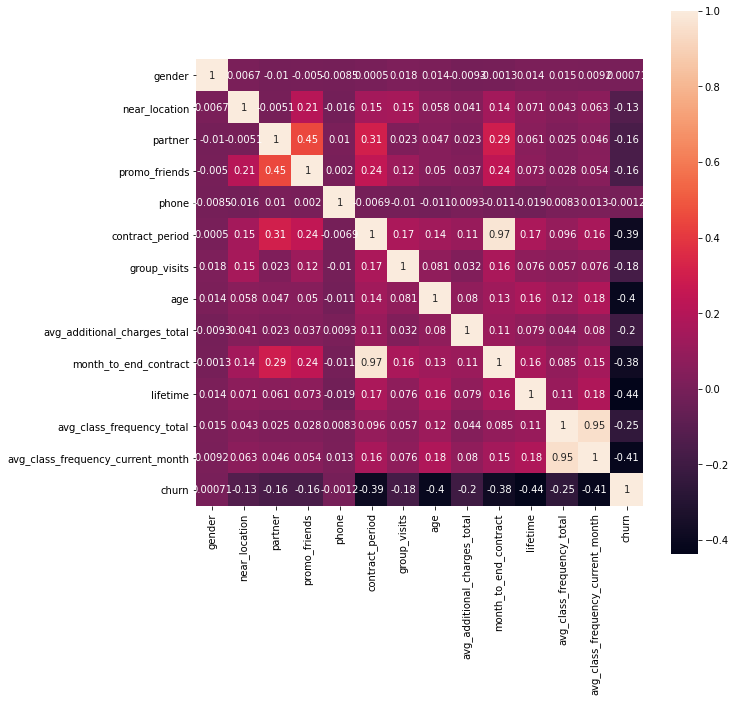

In [10]:
cm = data.corr() # вычисляем матрицу корреляций

plt.figure(figsize=(10, 10))

sns.heatmap(cm, annot=True, square=True) # тепловая карту с подписями для матрицы корреляций 

plt.show()

#### Выводы по матрице корреляции

По тепловой карте сложно сказать что-то определенное, но, похоже, наличие промо-кода и организации-партнера коррелируют друг с другом. А еще есть корреляция партнерской программы и периода контракта, а также наличия промо-кода и периода контракта. Видимо, в этих случаях льготный период оговорен заранее. Связь количества месяцев до конца контракта и наличие компании-партнера может указывать на конкретные сроки проведения акций партнеров. 

Очень высокая корреляция у длительности текущего действующего абонемента и срока до окончания текущего действующего абонемента. Но какие-либо выводы из этого факта делать не будем.

## Модель прогнозирования оттока клиентов
Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

Сначала разобьем данные на обучающую и валидационную выборку функцией train_test_split() в пропорции 8:2.

In [11]:
X = data.drop('churn', axis = 1)  # разделили данные на признаки (матрица X)
y = data['churn']                 # и целевую переменную (y)

X_train, X_test, y_train, y_test = (     # разделяем модель на обучающую и валидационную выборку
    train_test_split(X, y, 
                     test_size=0.2, 
                     random_state=0
                    )
)   

Стандартизируем данные.

In [12]:
scaler = StandardScaler()  #создадим объект класса StandardScaler
scaler.fit(X_train)         # обучаем scaler 
X_train_st = scaler.transform(X_train)   # применяем стандартизацию к матрицам признаков 
X_test_st = scaler.transform(X_test)

Обучим модель на train-выборке двумя способами:
- логистической регрессией,
- случайным лесом.

In [13]:
model = LogisticRegression(random_state=0, solver='liblinear')  # задали алгоритм для нашей модели - логистическую регрессию
model.fit(X_train_st, y_train)  # обучили модель
predictions = model.predict(X_test_st)  # прогноз для объектов из валидационного набора данных

Оценим метрики accuracy, precision и recall для этой модели (логистическая регрессия) на валидационной выборке. 

In [14]:
def metrics(y, y_pred):  # определим функцию для вывода требуемых метрик
    print('Accuracy: {:.2f}'.format(accuracy_score(y, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y, y_pred)))

In [15]:
metrics(y_test, predictions) # выведем требуемые метрики для полученного прогноза

Accuracy: 0.92
Precision: 0.85
Recall: 0.83


In [16]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)  # задали алгоритм - случайный лес с числом деревьев 100
rf_model.fit(X_train_st, y_train)  # обучили модель
rf_predictions = rf_model.predict(X_test_st)  # прогноз для объектов из валидационного набора данных

Оценим метрики accuracy, precision и recall для этой модели (случайный лес) на валидационной выборке.

In [17]:
metrics(y_test, rf_predictions)  # выведем требуемые метрики для этого полученного прогноза

Accuracy: 0.92
Precision: 0.84
Recall: 0.81


#### Выводы по полученным прогнозам

Сравним модели по этим метрикам: доля правильных ответов (accuracy), точность (precision) и полнота (recall). У первой модели выше точность и полнота при равных долях правильных ответов. Можно сказать, что модель логистическая регрессия показала себя лучше на основании этих метрик.

## Кластеризация клиентов

Проведем кластеризацию объектов (клиентов).

Стандартизируем данные.


In [18]:
scaler = StandardScaler() # создаём объект класса scaler (нормализатор)
X_sc = scaler.fit_transform(data.drop(columns = ['churn'])) # обучаем нормализатор и преобразуем набор данных 

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. 

### Дендрограмма

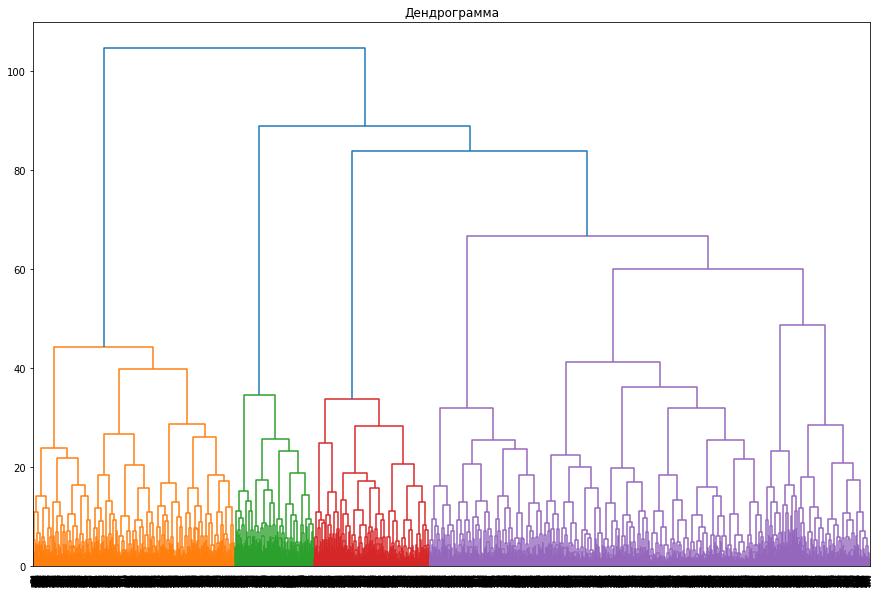

In [19]:
linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма')
plt.show() 

На основании полученного графика можно предположить, что можно выделить 4-5 кластеров (отрисовалось 4 кластера, но один из них слишком большой, возможно, его следует поделить пополам).

### Модель кластеризации на основании алгоритма K-Mean
Обучим теперь модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Договоримся за число кластеров принять n=5.

In [20]:
km = KMeans(n_clusters=5, random_state=0) # задали число кластеров, равное 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров 

data['cluster'] = labels   # сохраняем метки кластера в поле нашего датасета

На основе дэтой кластеризации создадим датасет, содержащий средние по кластеру значения и количество попавших в этот кластер посетителей. Для каждого полученного кластера доля оттока - это значения в столбце 'churn', равные среднему арифметическому.

In [21]:
data_group = data.groupby('cluster').mean()   # Группируем по столбцу 'cluster' и находим среднее значение каждого признака

data_group['count'] = data.groupby('cluster')['age'].count()  # подсчитываем размер кластеров по любому столбцу (здесь 'age')

pd.set_option('display.float_format', '{:.2f}'.format)  # Все числа float в таблице будут отражаться с 2 знаками после запятой
data_group.T   # транспонируем для удобства и выводим статистику по средним значениям имеющихся признаков по кластеру

cluster,0,1,2,3,4
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
contract_period,10.89,4.79,2.35,1.95,2.67
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional_charges_total,160.76,143.96,135.46,131.62,161.66
month_to_end_contract,9.95,4.48,2.20,1.86,2.46


#### Предварительные выводы по кластеризации
Как мы заметили раньше, кластеры сильно различаются по доле оттока. Если посмотреть на средние значения целевого признака "churn" (доли оттока) для кластеров, можно было бы выделить не пять, а три кластера. Максимальный отток у кластеров №2 и № 3, а самые надежные - №0 и №4. Кластер № 1 занимает промежуточное положение.

Также создается впечатление, что признак "phone" вообще мешается (как будто по нему отобран кластер 1), а кластеры 2 и 3 разделены по признаку удаленности от фитнес-центра. 

Если смотреть на кластеры 0 и 4, получается, у них значительное отличие в длительности контракта и количестве занятий в неделю, при этом размеры кластеров сопоставимы. То есть длительность контракта не является определяющей, а вот количество занятий в неделю, хоть и отличается на целый день (почти 2 и почти 3), но в среднем больше, чем в остальных кластерах, показывающих больший отток. 


### Гистограммы распределения признаков для кластеров. 
Построим распределения признаков для кластеров. 

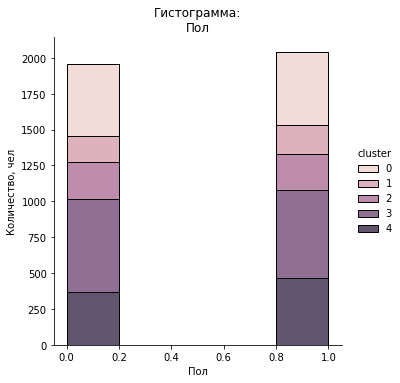

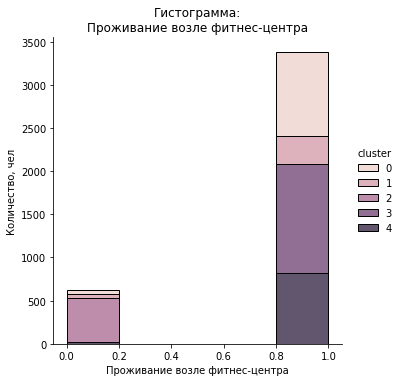

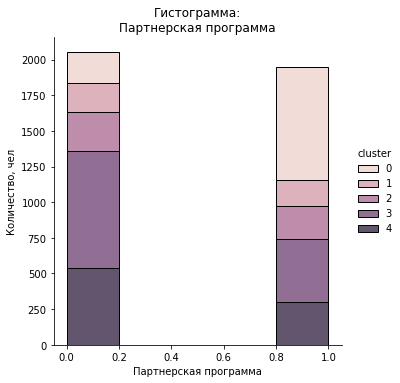

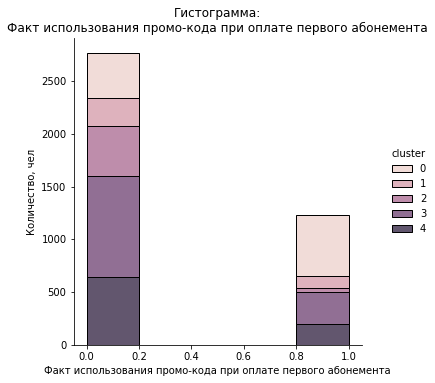

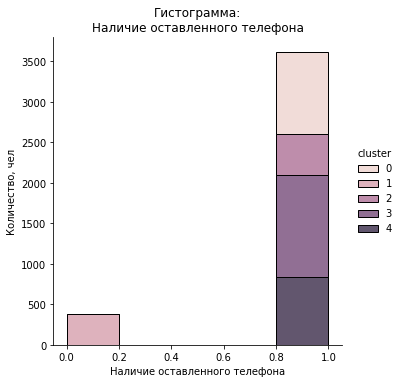

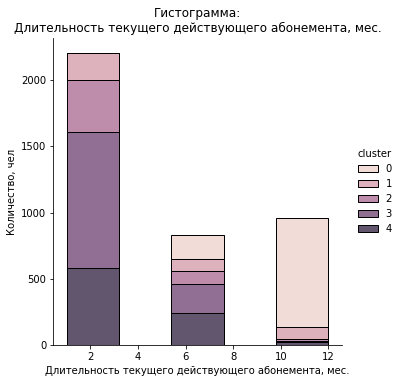

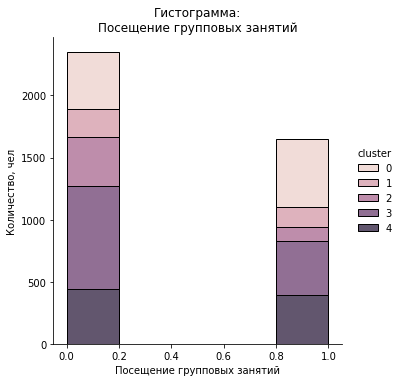

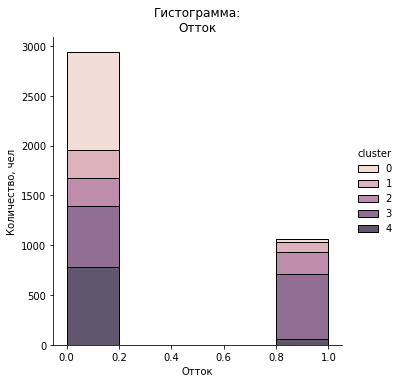

In [22]:
for column in col_discrete:    # для группы условно дискретных признаков
    sns.displot(x=column,
            hue='cluster',
            bins = 5,
            multiple='stack',
            data=data)
    
    plt.ylabel('Количество, чел')
    plt.xlabel(titles.get(column))
    plt.title('Гистограмма:\n'+ titles.get(column))
    plt.show()    

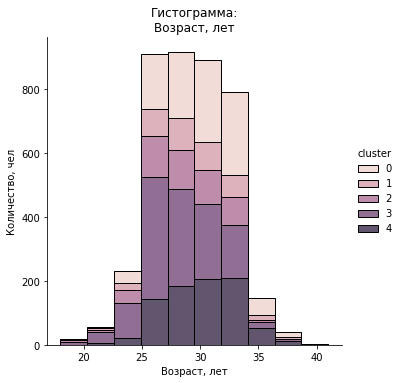

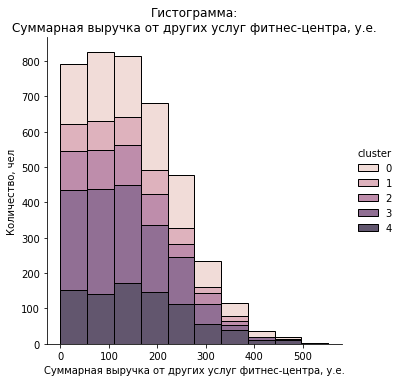

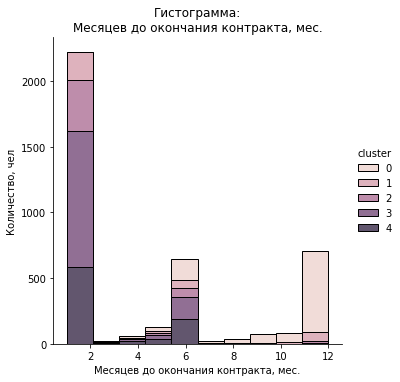

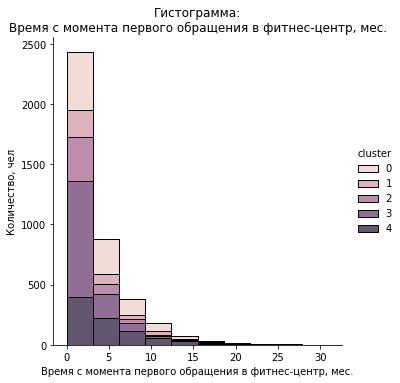

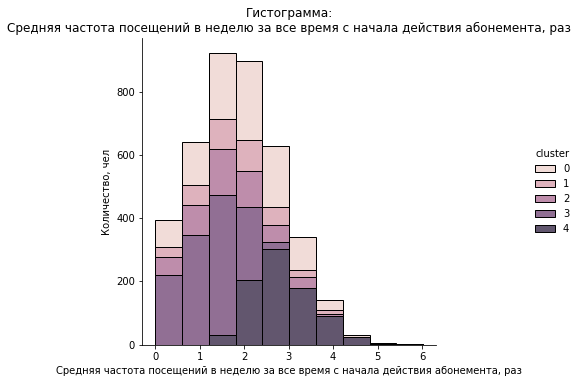

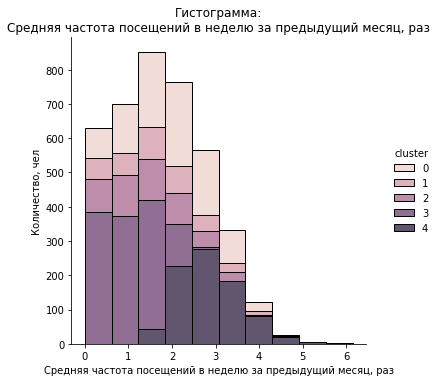

In [23]:
for column in col_continuous:   # для группы условно непрерывных признаков
    sns.displot(x=column,
            hue='cluster',
            bins = 10,
            multiple='stack',
            data=data)
    
    plt.ylabel('Количество, чел')
    plt.xlabel(titles.get(column))
    plt.title('Гистограмма:\n'+ titles.get(column))
    plt.show()   

Здесь хорошо видно, что больше всего редко ходящих клиентов в третьем кластере, где большой отток, а чаще всего ходят посетители, отнесенные к четвертому кластеру, где отток мал.

## Выводы и базовые рекомендации по работе с клиентами

Главная задача - привлечь клиентов и удержать их. На основе проанализированных данных можно сказать, что чем дольше клиент остается, тем меньше вероятность его дальнейшего ухода. Есть связь меньшего оттока и большего вложения денег в дополнительные услуги. Положительно влияют наличие промо-кода и скидок от организации-партнера. Среди тех, кто проживает или работает в районе, где находится фитнес-центр, доля оттока значительно меньше.

Возможные рекомендации.
- Проведение промо-акций для знакомства с фитнес-центром (например, использование промо-кода от знакомого в рамках акции «приведи друга» при оплате первого абонемента)
- Скидки на абонементы (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент).
- Более широкий спектр дополнительных услуг.
- Привлечение клиентов, преимущественно живущих или работающих в непосредственной близости от фитнес-центра.
- Предпочтительная продажа абонементов на более длительный срок (6-12 месяцев).